In [1]:
import os
os.chdir('/grid_mnt/data_cms_upgrade/biriukov/TICL_Validation/python')
from validation.DataFile import *
from validation.DataProcessor import *
from validation.NTupler import *
from validation.Plotter import *
from typing import List, Union, Tuple

# for plotting 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import mplhep as hep
plt.style.use(hep.style.CMS)
e_5_30_pu0 = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_5_30/step3_no_PU/14_2_0_pre1/dumper/dumper_merged.root'
e_5_30_pu200 = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_5_30/step3/14_2_0_pre1/dumper/dumper_merged.root'
e_10_1000_pu0 = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_10_1000/step3_no_PU/14_2_0_pre1/dumper/dumper_merged.root'
e_10_1000_pu200 = '/grid_mnt/data_cms_upgrade/biriukov/data/photons_D110_E_10_1000/step3/14_2_0_pre1/dumper/dumper_merged_1_30.root'
filepath = {
    'e_5_30_pu0': e_5_30_pu0,
    'e_5_30_pu200': e_5_30_pu200,
    'e_10_1000_pu0': e_10_1000_pu0,
    'e_10_1000_pu200': e_10_1000_pu200
}

tfile = DataFile(filepath['e_10_1000_pu200'])

In [2]:
test_data = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key='id_probabilities')
binning_test = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="raw_pt")
recoToSim_score = tfile.openArray(branch_name='ticlDumper/associations', key='tsCLUE3D_recoToSim_CP_score')

In [3]:
gm_binning = binning_test[recoToSim_score[:, :, 0] < 0.2]
gm_data = test_data[recoToSim_score[:, :, 0] < 0.2]

In [12]:
ak.flatten(gm_data[gm_binning > 10.])[:,1]

<Array [0.48, 0.654, 0.127, ..., 0.367, 0.0212, 0.732] type='2899 * float32'>

# PID scores

The goal of this notebook is to compute distribution probabilities of reconstructed object to be of EM origin. In trees such as `"ticlDumper/trackstersCLUE3DHigh"` or `"ticlDumper/trackstersTiclCandidate"` (they correspond to reconstructed objects), one can find a branch `"id_probabilities"`. For each reconstracted object, `"id_probabilities"` contains a vector of 8 numbers corresponding to probabilities of a reconstracted object being of origin of a particular object. 

In [24]:
# data_key = "id_probabilities"
# binning_keys -- list of pairs (branch_name, key)
# nbins -- list of number of bins for each pair of binning_keys
# binning_opt -- list of options for binning (either equal width ('lin') or equal log width ('log'))

def processData(data_key: str,
                binning_keys: List[Tuple[str, str]], 
                nbins: List[int],
                binning_opt: List[str],
                gen_match: bool = False
                ):
    if len(binning_keys) != len(nbins):
        raise ValueError(f'Number of pairs of binning keys must be equal to length of nbins (current: {len(binning_keys)}, {len(nbins)})')
    
    if len(binning_keys) != len(binning_opt):
        raise ValueError(f'Number of pairs of binning keys must be equal to number of binning options')
    
    var_dict = {
        'eta': r'$\eta$',
        'phi': r'$\phi$',
        'e_raw': r'$E_\text{reco}^\text{raw}$',
        'e_reg': r'$E_\text{reco}^\text{regressed}$',
        'e_seed': r'$E_\text{seed}$',
        'pT': r'p_T'
    }

    binning_path = {
        'eta': ('ticlDumper/trackstersCLUE3DHigh', 'barycenter_eta'),
        'phi': ('ticlDumper/trackstersCLUE3DHigh', 'barycenter_phi'), 
        'e_raw': ('ticlDumper/trackstersCLUE3DHigh', 'raw_energy'),
        'e_reg': ('ticlDumper/trackstersCLUE3DHigh', 'regressed_energy'),
        'e_seed': ('ticlDumper/simtrackstersCP', 'raw_energy'),
        'pT': ('ticlDumper/trackstersCLUE3DHigh', 'raw_pt')
    }

    # Extract data
    id_prob= tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key=data_key)

    # Clean PU
    if gen_match:
        recoToSim_score = tfile.openArray(branch_name='ticlDumper/associations', key='tsCLUE3D_recoToSim_CP_score')[:, :, 0]
        id_prob = id_prob[recoToSim_score < 0.2]

    # Extract binning data
    binning_arrays = []
    for key in binning_keys:
        bin_key = binning_path[key]
        binning_data = tfile.openArray(bin_key[0], bin_key[1])
        if gen_match:
            binning_data = binning_data[recoToSim_score < 0.2]
        binning_arrays.append(binning_data)


    # Make binning edges
    bin_edges = []
    for binning_array, nb, b_opt in zip(binning_arrays, nbins, binning_opt):
        min_bin = np.min(binning_array)
        max_bin = np.max(binning_array)
        if b_opt == 'lin':
            bin_edges.append(np.linspace(min_bin, max_bin, nb + 1))
        if b_opt == 'log':
            min_bin = {True: 5, False: min_bin}[min_bin < 5]                # regularization of minimal bin (log10(0) undefined)
            bin_edges.append(np.logspace(np.log10(min_bin), np.log10(max_bin), nb + 1))

    # Separating data in bins of binning variables
    id_prob_in_bins = []
    plotLabels = []
    for edges_array, key, binning_array in zip(bin_edges, binning_keys, binning_arrays):
        id_prob_per_edges = []
        plotLabels_per_edges = []
        for bin in range(len(edges_array) - 1):
            min_bin = edges_array[bin]
            max_bin = edges_array[bin + 1]
            var = var_dict[key]
            plotLabel = f'{min_bin:.2f} < {var} < {max_bin:.2f}'
            if key.split('_')[0] == 'e':
                plotLabel += ' GeV'
            plotLabels_per_edges.append(plotLabel)

            bin_map = (binning_array > min_bin) & (binning_array < max_bin)
            id_prob_per_bin = ak.flatten(id_prob[bin_map])
            id_prob_per_edges.append(id_prob_per_bin)
        id_prob_in_bins.append(id_prob_per_edges)
        plotLabels.append(plotLabels_per_edges)
                  
    em_prob_in_bins = []
    for i, var in enumerate(id_prob_in_bins):
        em_prob_per_var = []
        for bin in var:
            em_prob_per_bin = bin[:, 0] + bin[:, 1]
            em_prob_per_var.append(np.array(em_prob_per_bin))
        em_prob_in_bins.append(em_prob_per_var)

    em_prob_comb = np.concatenate(em_prob_in_bins[0])

    return em_prob_comb, em_prob_in_bins, plotLabels

def makeHists(data: Tuple[List, List, List],
              nbins: int):
    # make histograms
    hist_in_bins = []
    bin_edges = np.linspace(0, 1, nbins + 1)

    hist_comb, _ = np.histogram(data[0], bin_edges)

    for var in data[1]:
        hists_per_var = [[], [], []]
        for bin in var:
            hist, _ = np.histogram(bin, bin_edges)
            hists_per_var[0].append(hist)
            hists_per_var[1].append(bin_edges)
            hists_per_var[2].append(np.sqrt(hist))
        hist_in_bins.append(hists_per_var)

    norm_hist_in_bins = []
    for var in hist_in_bins:
        hists = var[0]
        n_events_per_hist = np.array([np.sum(h) for h in hists])
        weights = n_events_per_hist[0]/n_events_per_hist

        norm_hists = [hists[j]*weights[j] for j in range(len(weights))]
        propagated_errors = [var[2][j]*weights[j] for j in range(len(weights))]
        norm_hists_per_var = [[], [], []]
        for hist in norm_hists:
            norm_hists_per_var[0].append(hist)
        for bins in var[1]:
            norm_hists_per_var[1].append(bins)
        for error in propagated_errors:
            norm_hists_per_var[2].append(error)
        norm_hist_in_bins.append(norm_hists_per_var)

    return [hist_comb, bin_edges, np.sqrt(hist_comb)], hist_in_bins, norm_hist_in_bins
    
def makePlot(hist: List[float],
             bins: List[float],
             error: List[float],
             plotLabel: str=None,
             gen_match: bool=False):
    fig, ax = plt.subplots()
    bin_centers = (bins[1:] + bins[:-1])/2
    ax.fill_between(bin_centers, hist - error, hist + error, step='mid', alpha=0.2, color='grey')
    bins = np.repeat(bins, 2)
    hist = np.concatenate([[0], np.repeat(hist, 2), [0]])

    ax.step(bins, hist, where='post', linewidth=2, label=plotLabel)

    ax.set_ylim(0)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Pr(EM)')
    ax.set_ylabel('events')
    hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
    hep.cms.lumitext("PU=0", ax=ax)

def makePlotSequence(hists: List[List[float]],
                     bins: List[float],
                     errors: List[List[float]],
                     plotLabels: List[str],
                     gen_match: bool=False):
    
    if len(plotLabels) != len(hists):
        raise TypeError(f'Number of labels (current values = {len(plotLabels)}) must be equal to number of histograms (current value = {len(hists)})')
    bin_centers = (bins[1:] + bins[:-1])/2
    bins = np.repeat(bins, 2)
    max_y = np.max(np.array(hists))

    fig, ax = plt.subplots()
    for hist, error, plotLabel in zip(hists, errors, plotLabels):
        ax.fill_between(bin_centers, hist - error, hist + error, step = 'mid', alpha=0.2, color='grey')
        hist = np.concatenate([[0], np.repeat(hist, 2), [0]])
        ax.step(bins, hist, where='post', linewidth=2, label=plotLabel)
        ax.set_ylim(0, 1.1*max_y)
        ax.set_xlim(0, 1)
        ax.set_xlabel('Pr(EM)')
        ax.set_ylabel('events')
        #ax.set_yscale('log')
        ax.legend()
        hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
        if gen_match:
            hep.cms.lumitext("PU=200", ax=ax)
        else:
            hep.cms.lumitext("PU=0", ax=ax)       

In [25]:
data_key = "id_probabilities"
binning_keys = ["eta", "phi", "e_raw", "e_reg", "pT"]
nbins = [3, 6, 6, 6, 6]
binning_opt = ["lin", "lin", "log", "log", "log"]
gen_match = True

data = processData(data_key, binning_keys, nbins, binning_opt, gen_match=True)
hists = makeHists(data, 15)

In [ ]:
makePlot(*hists[0], gen_match)

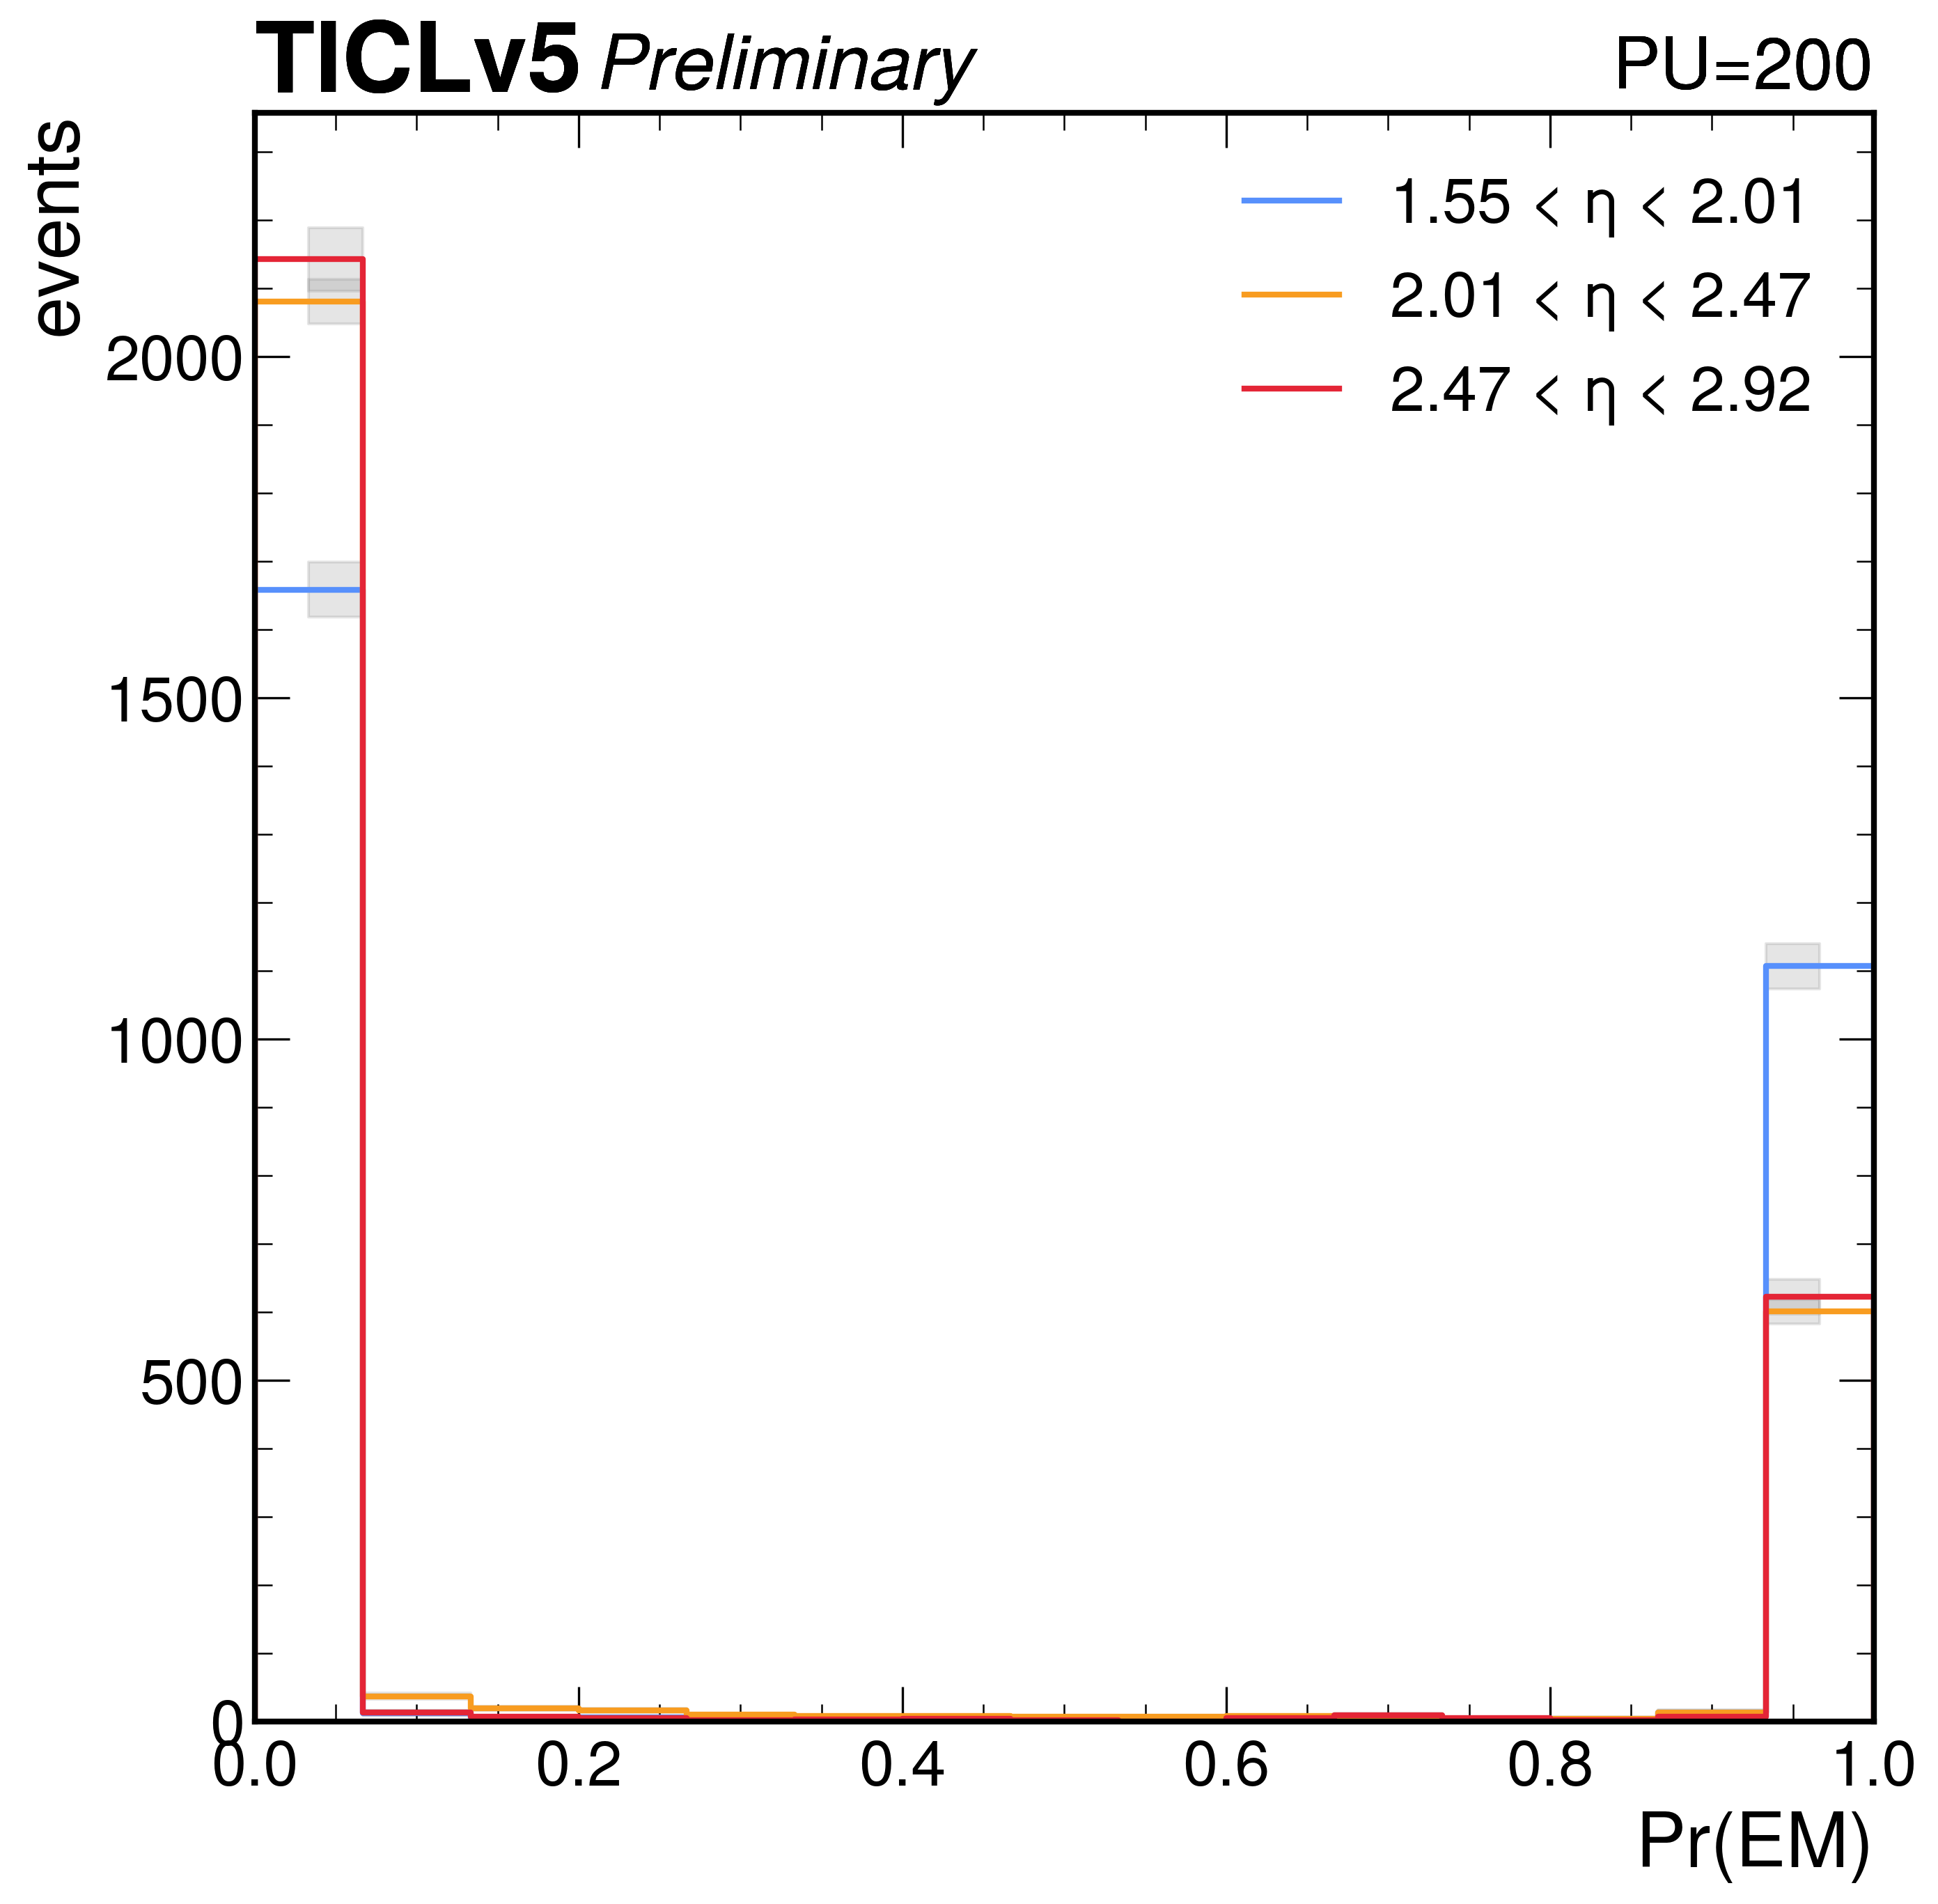

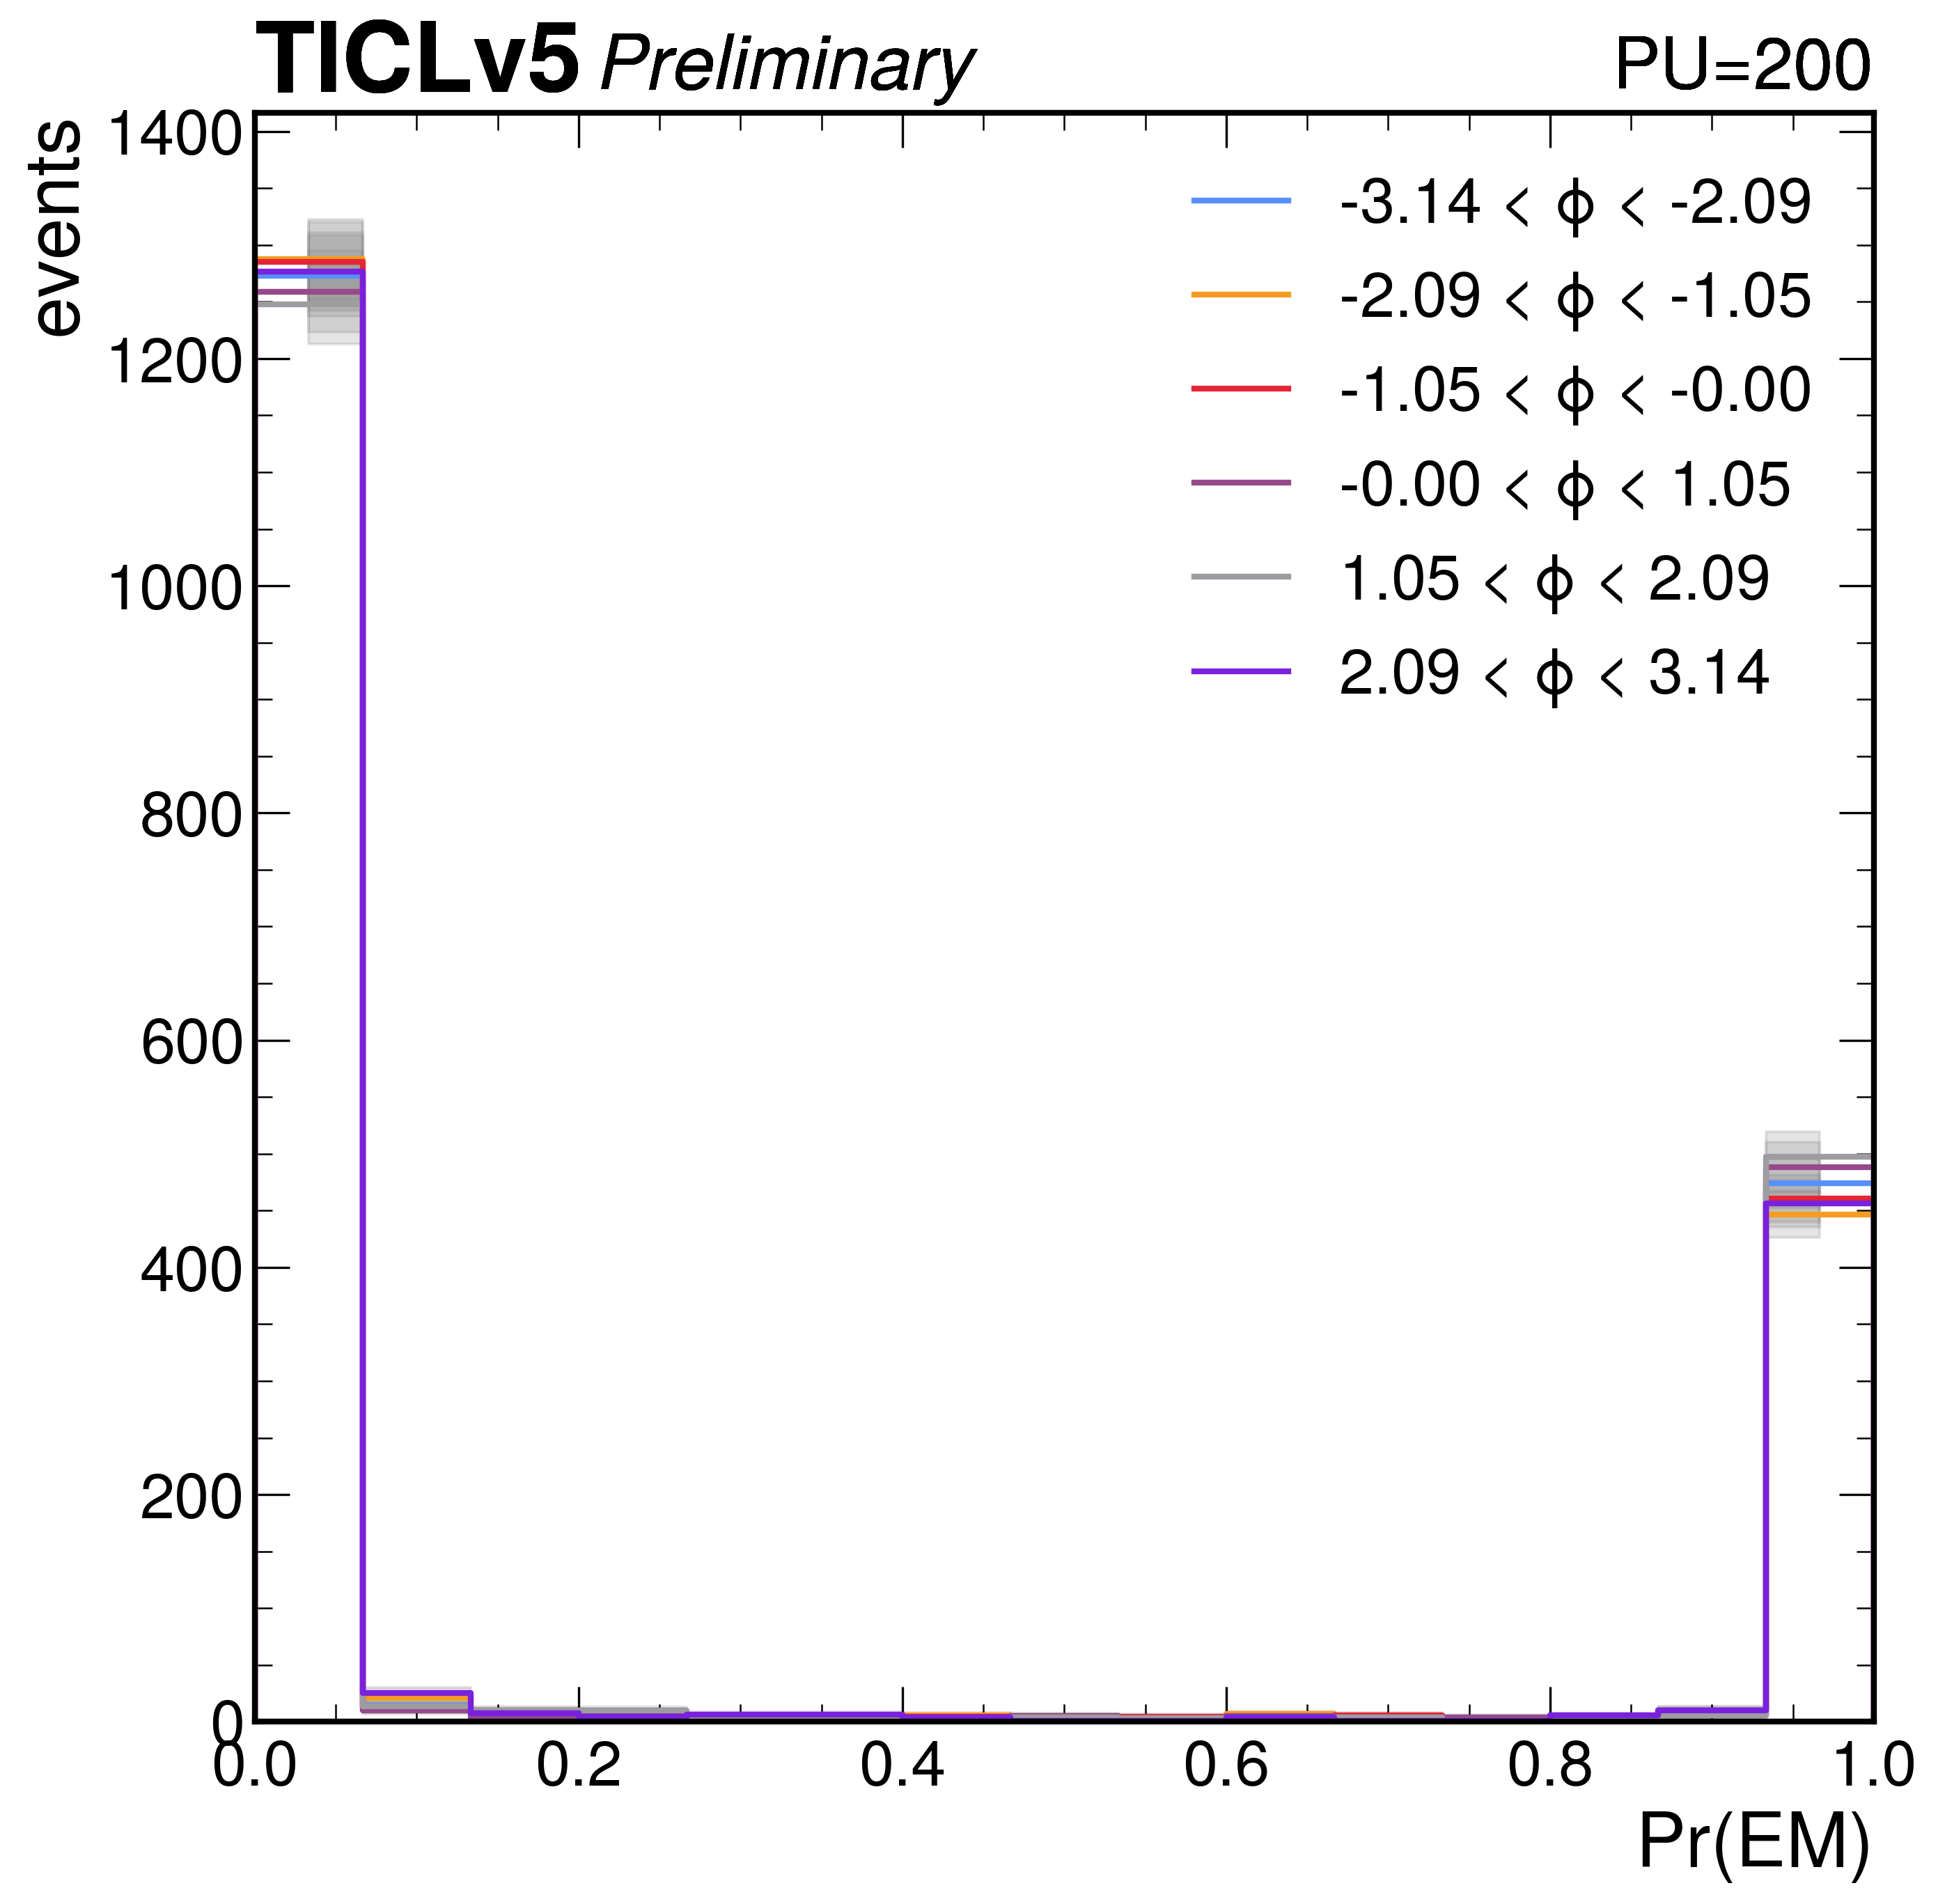

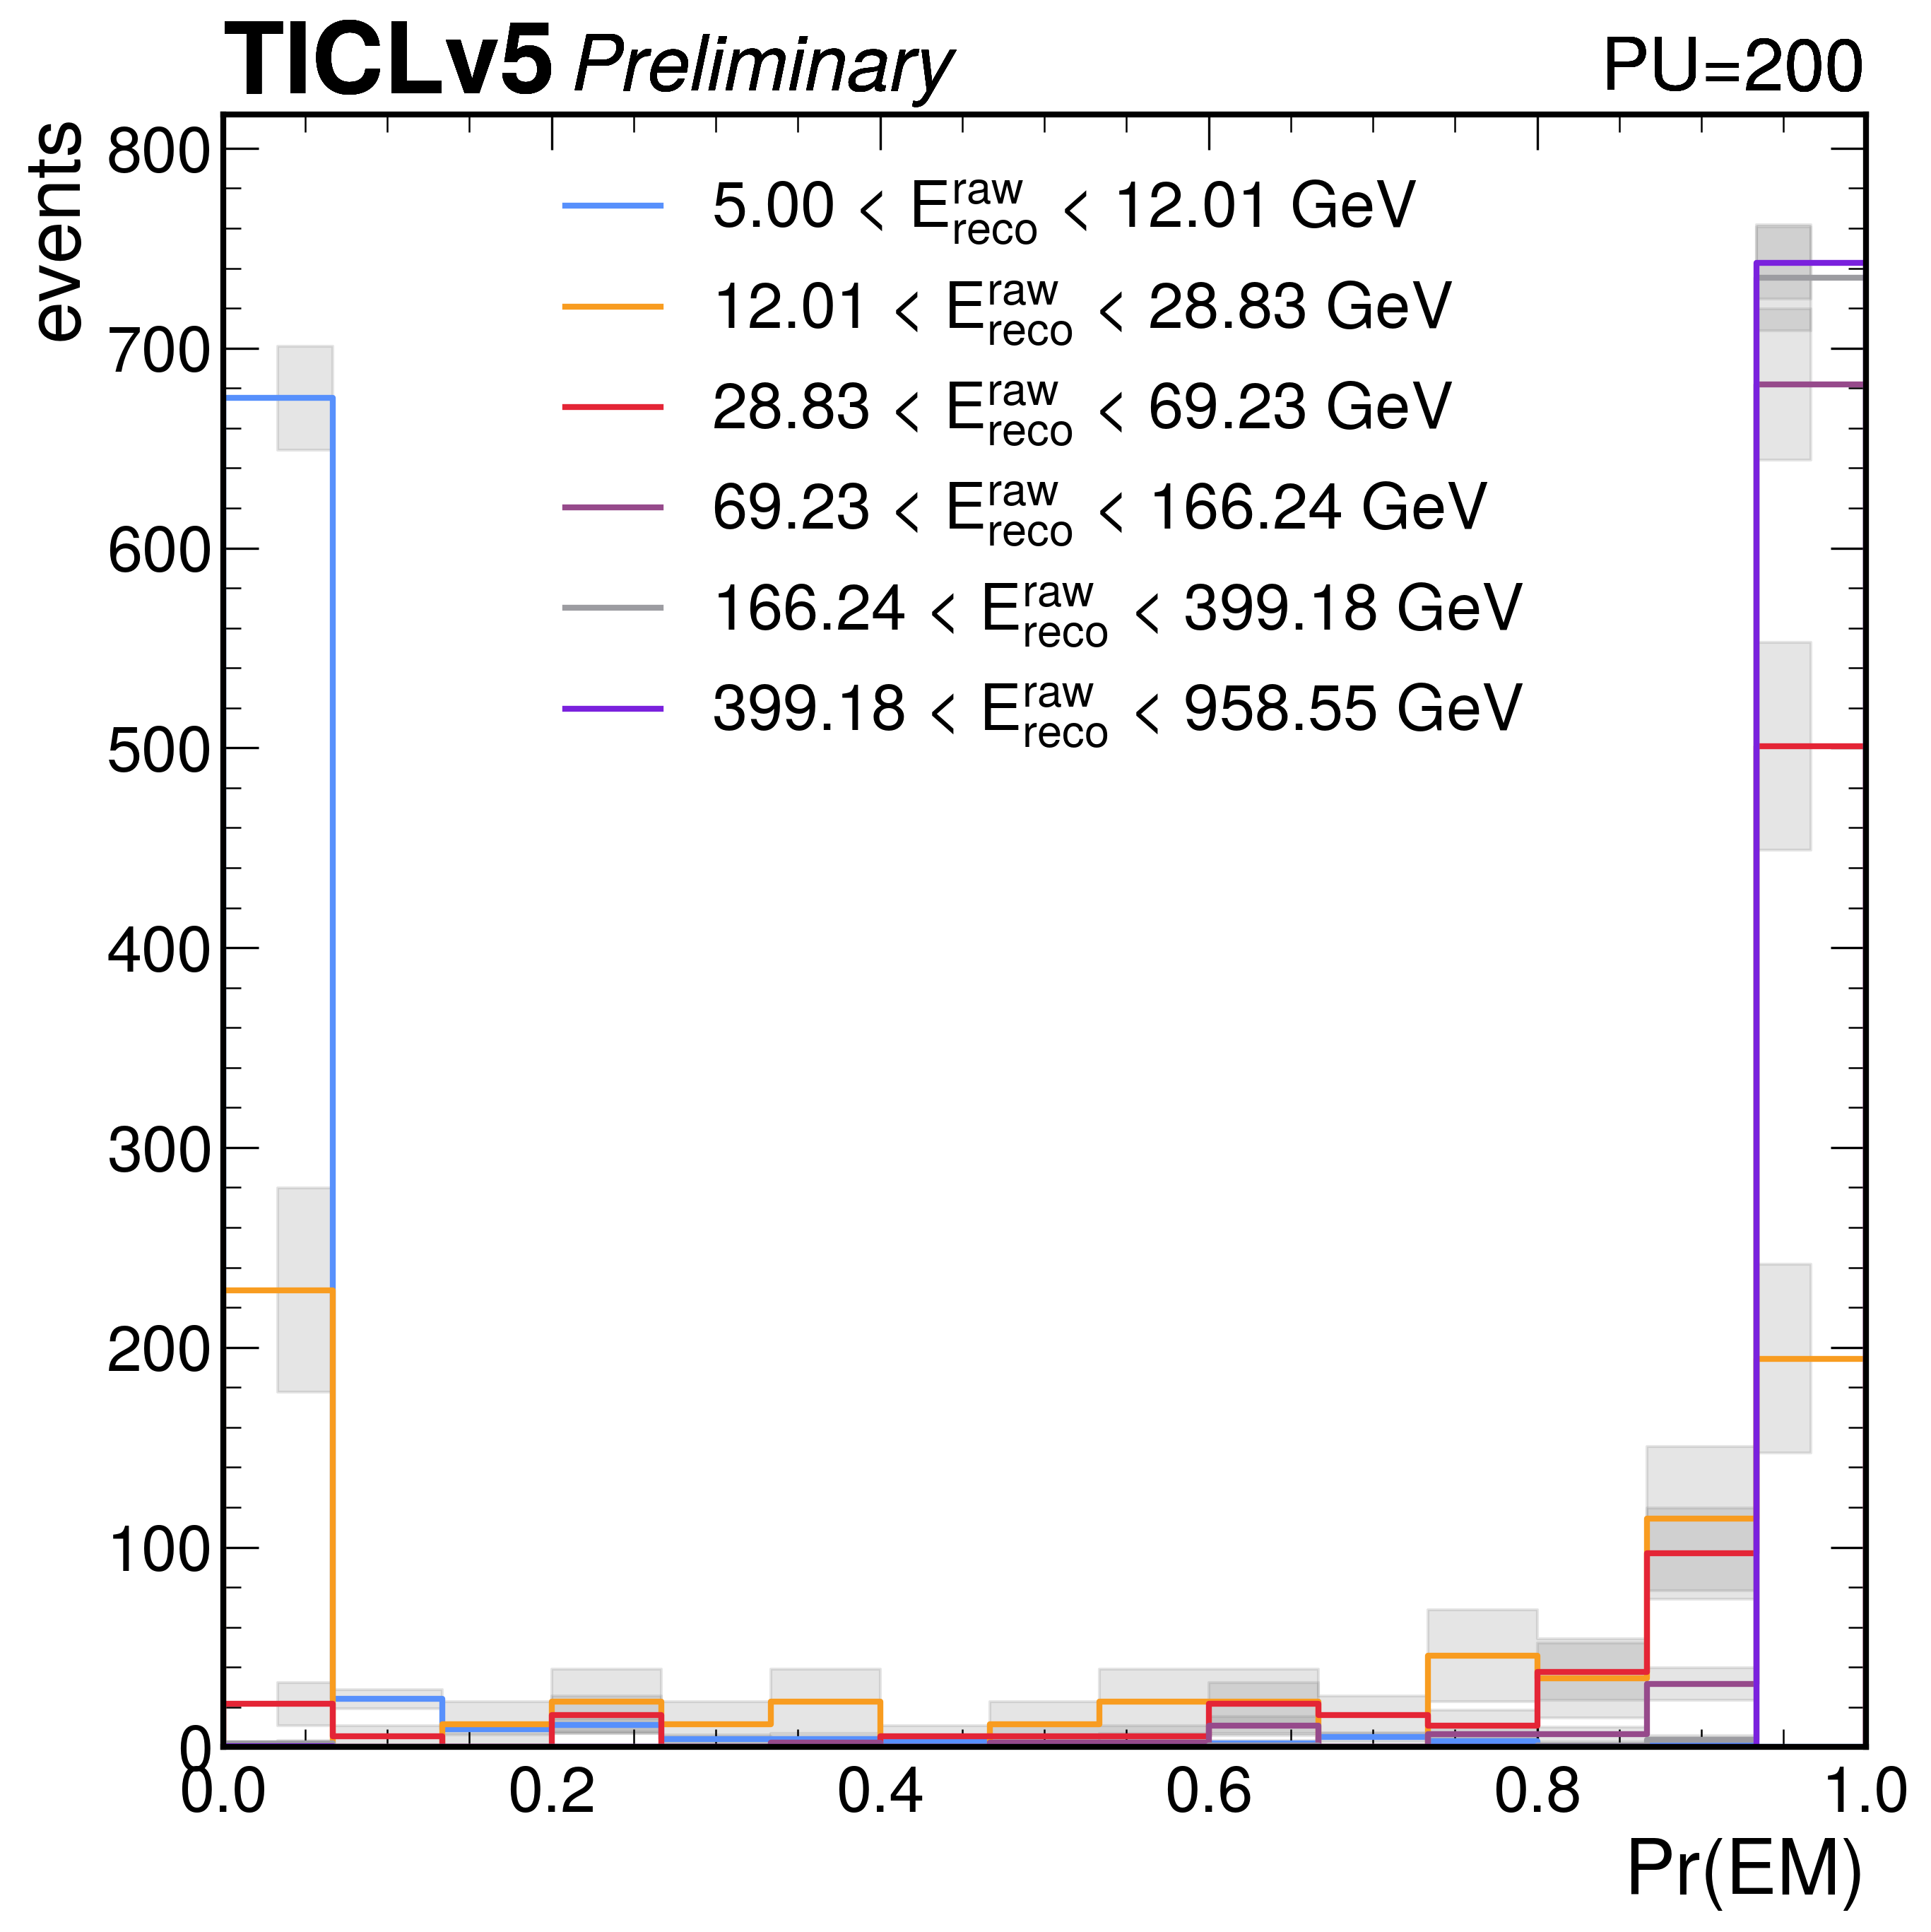

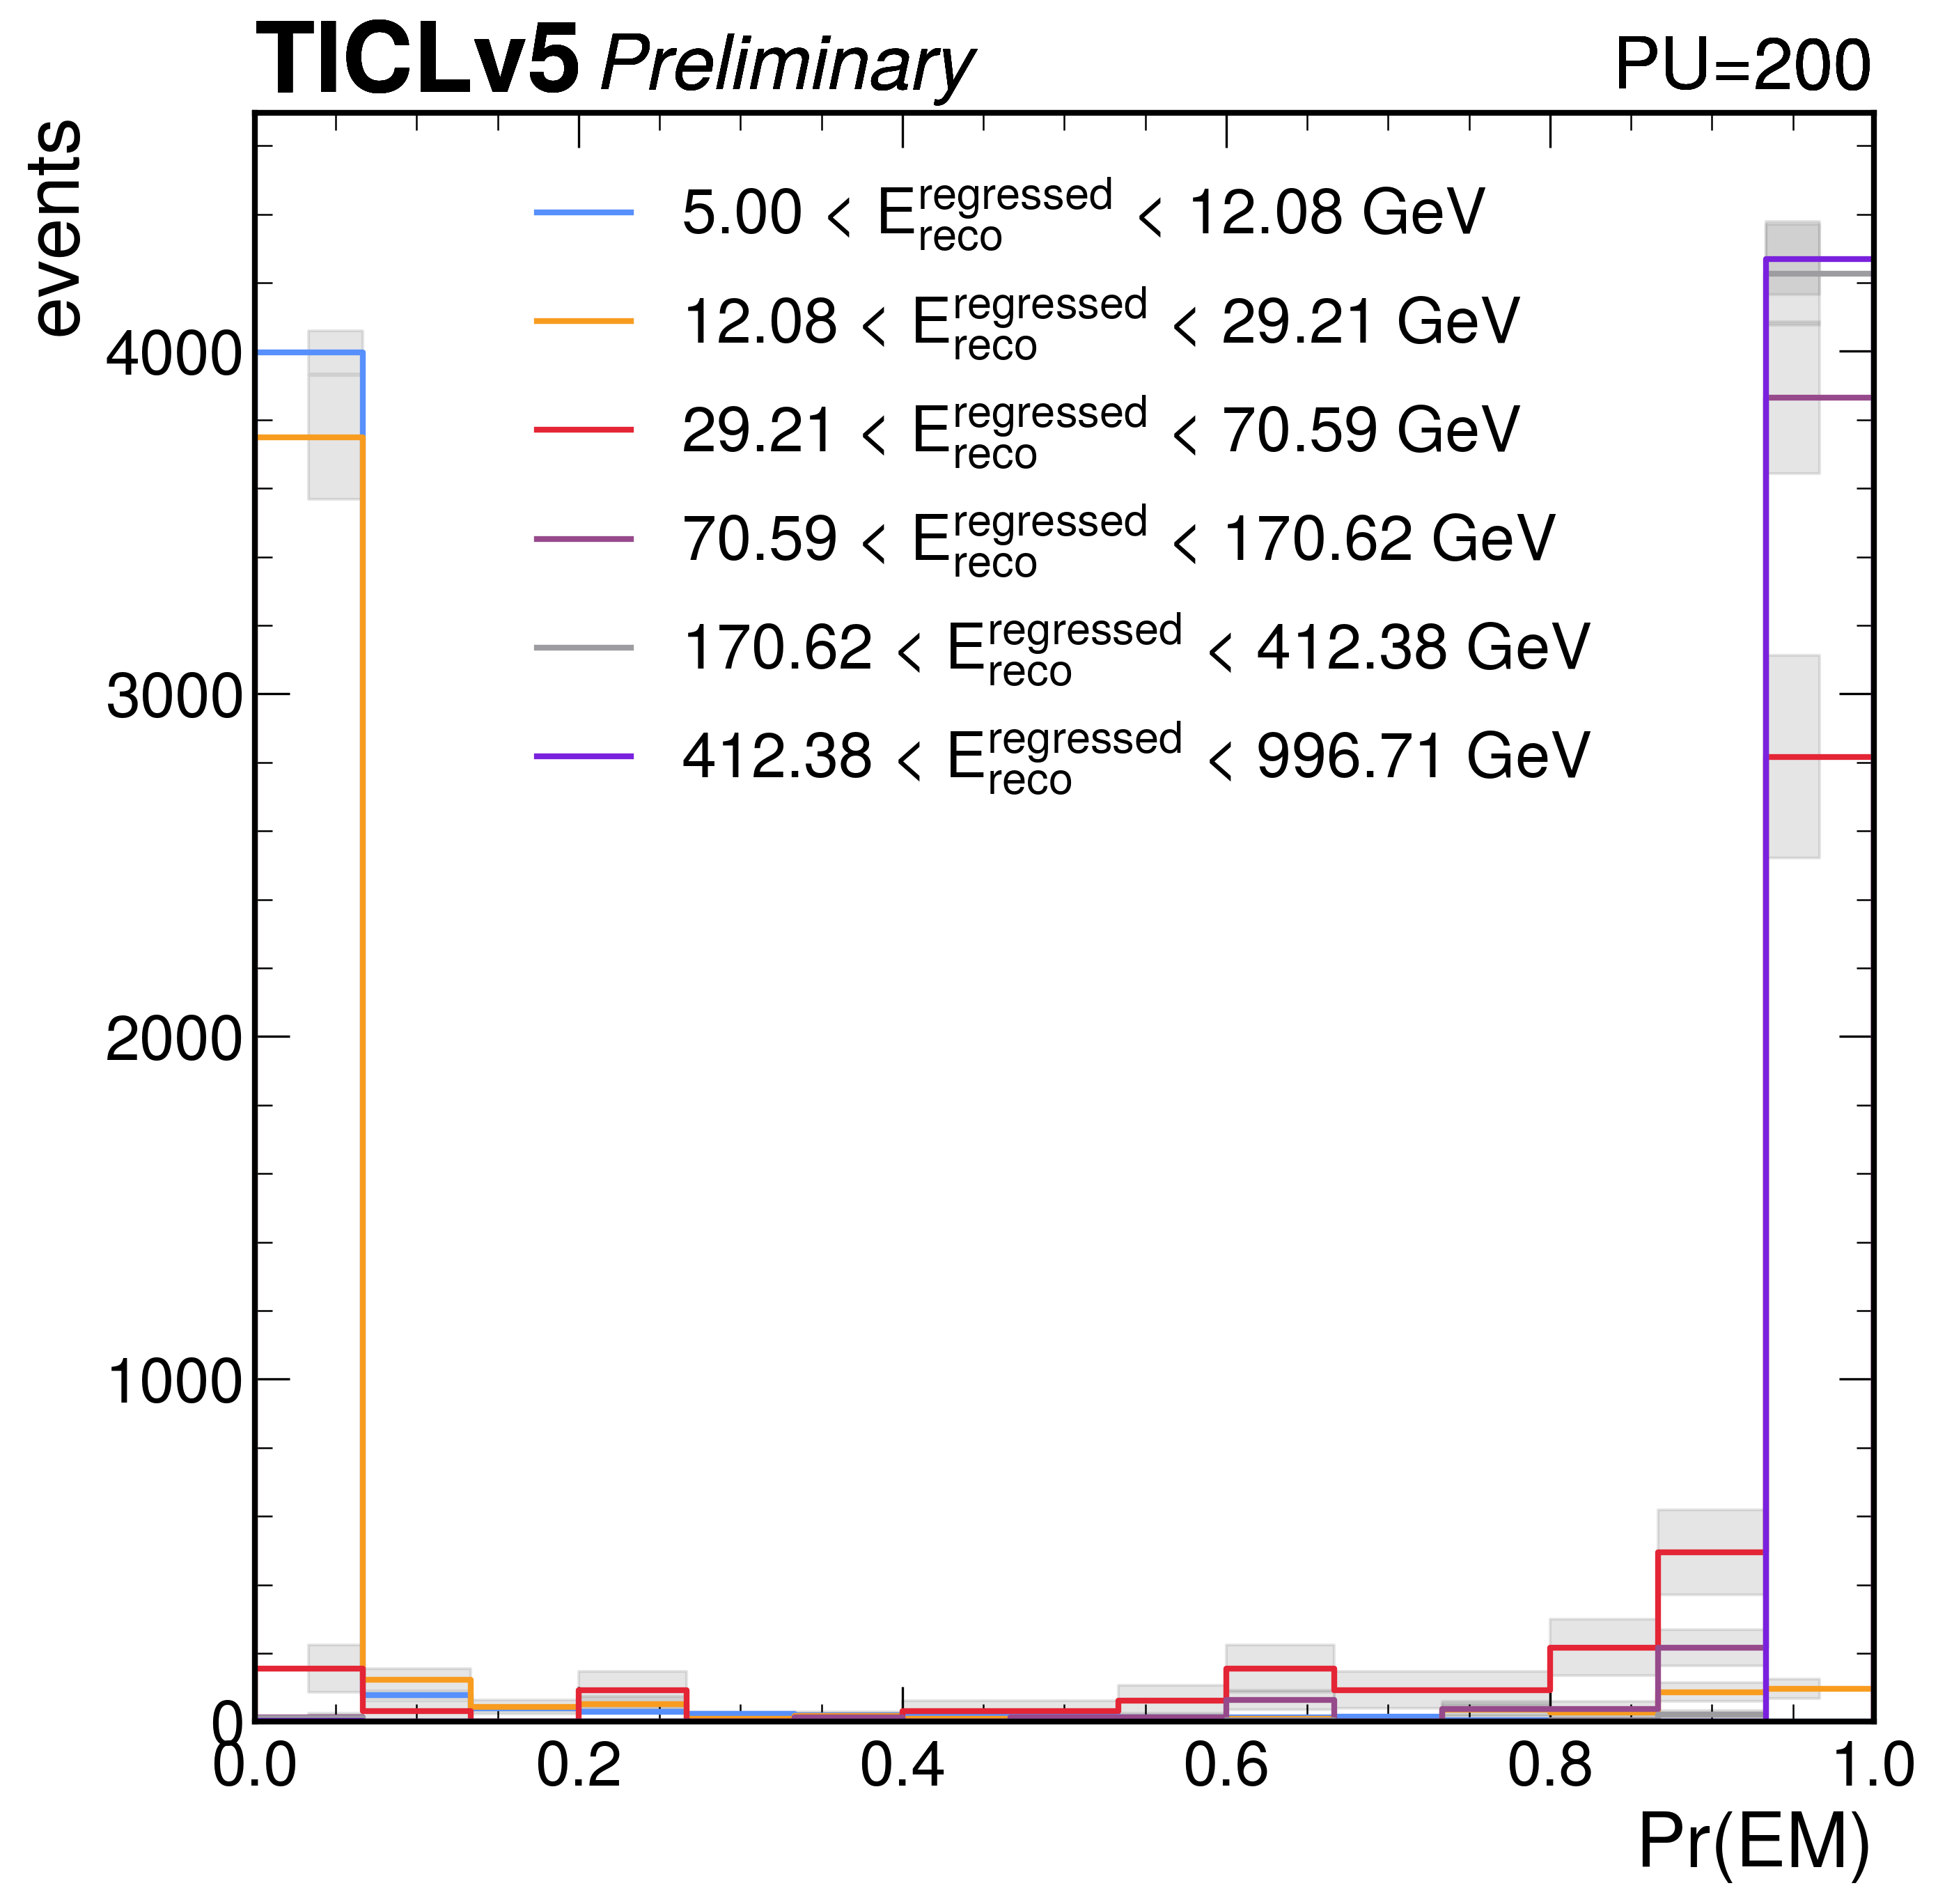

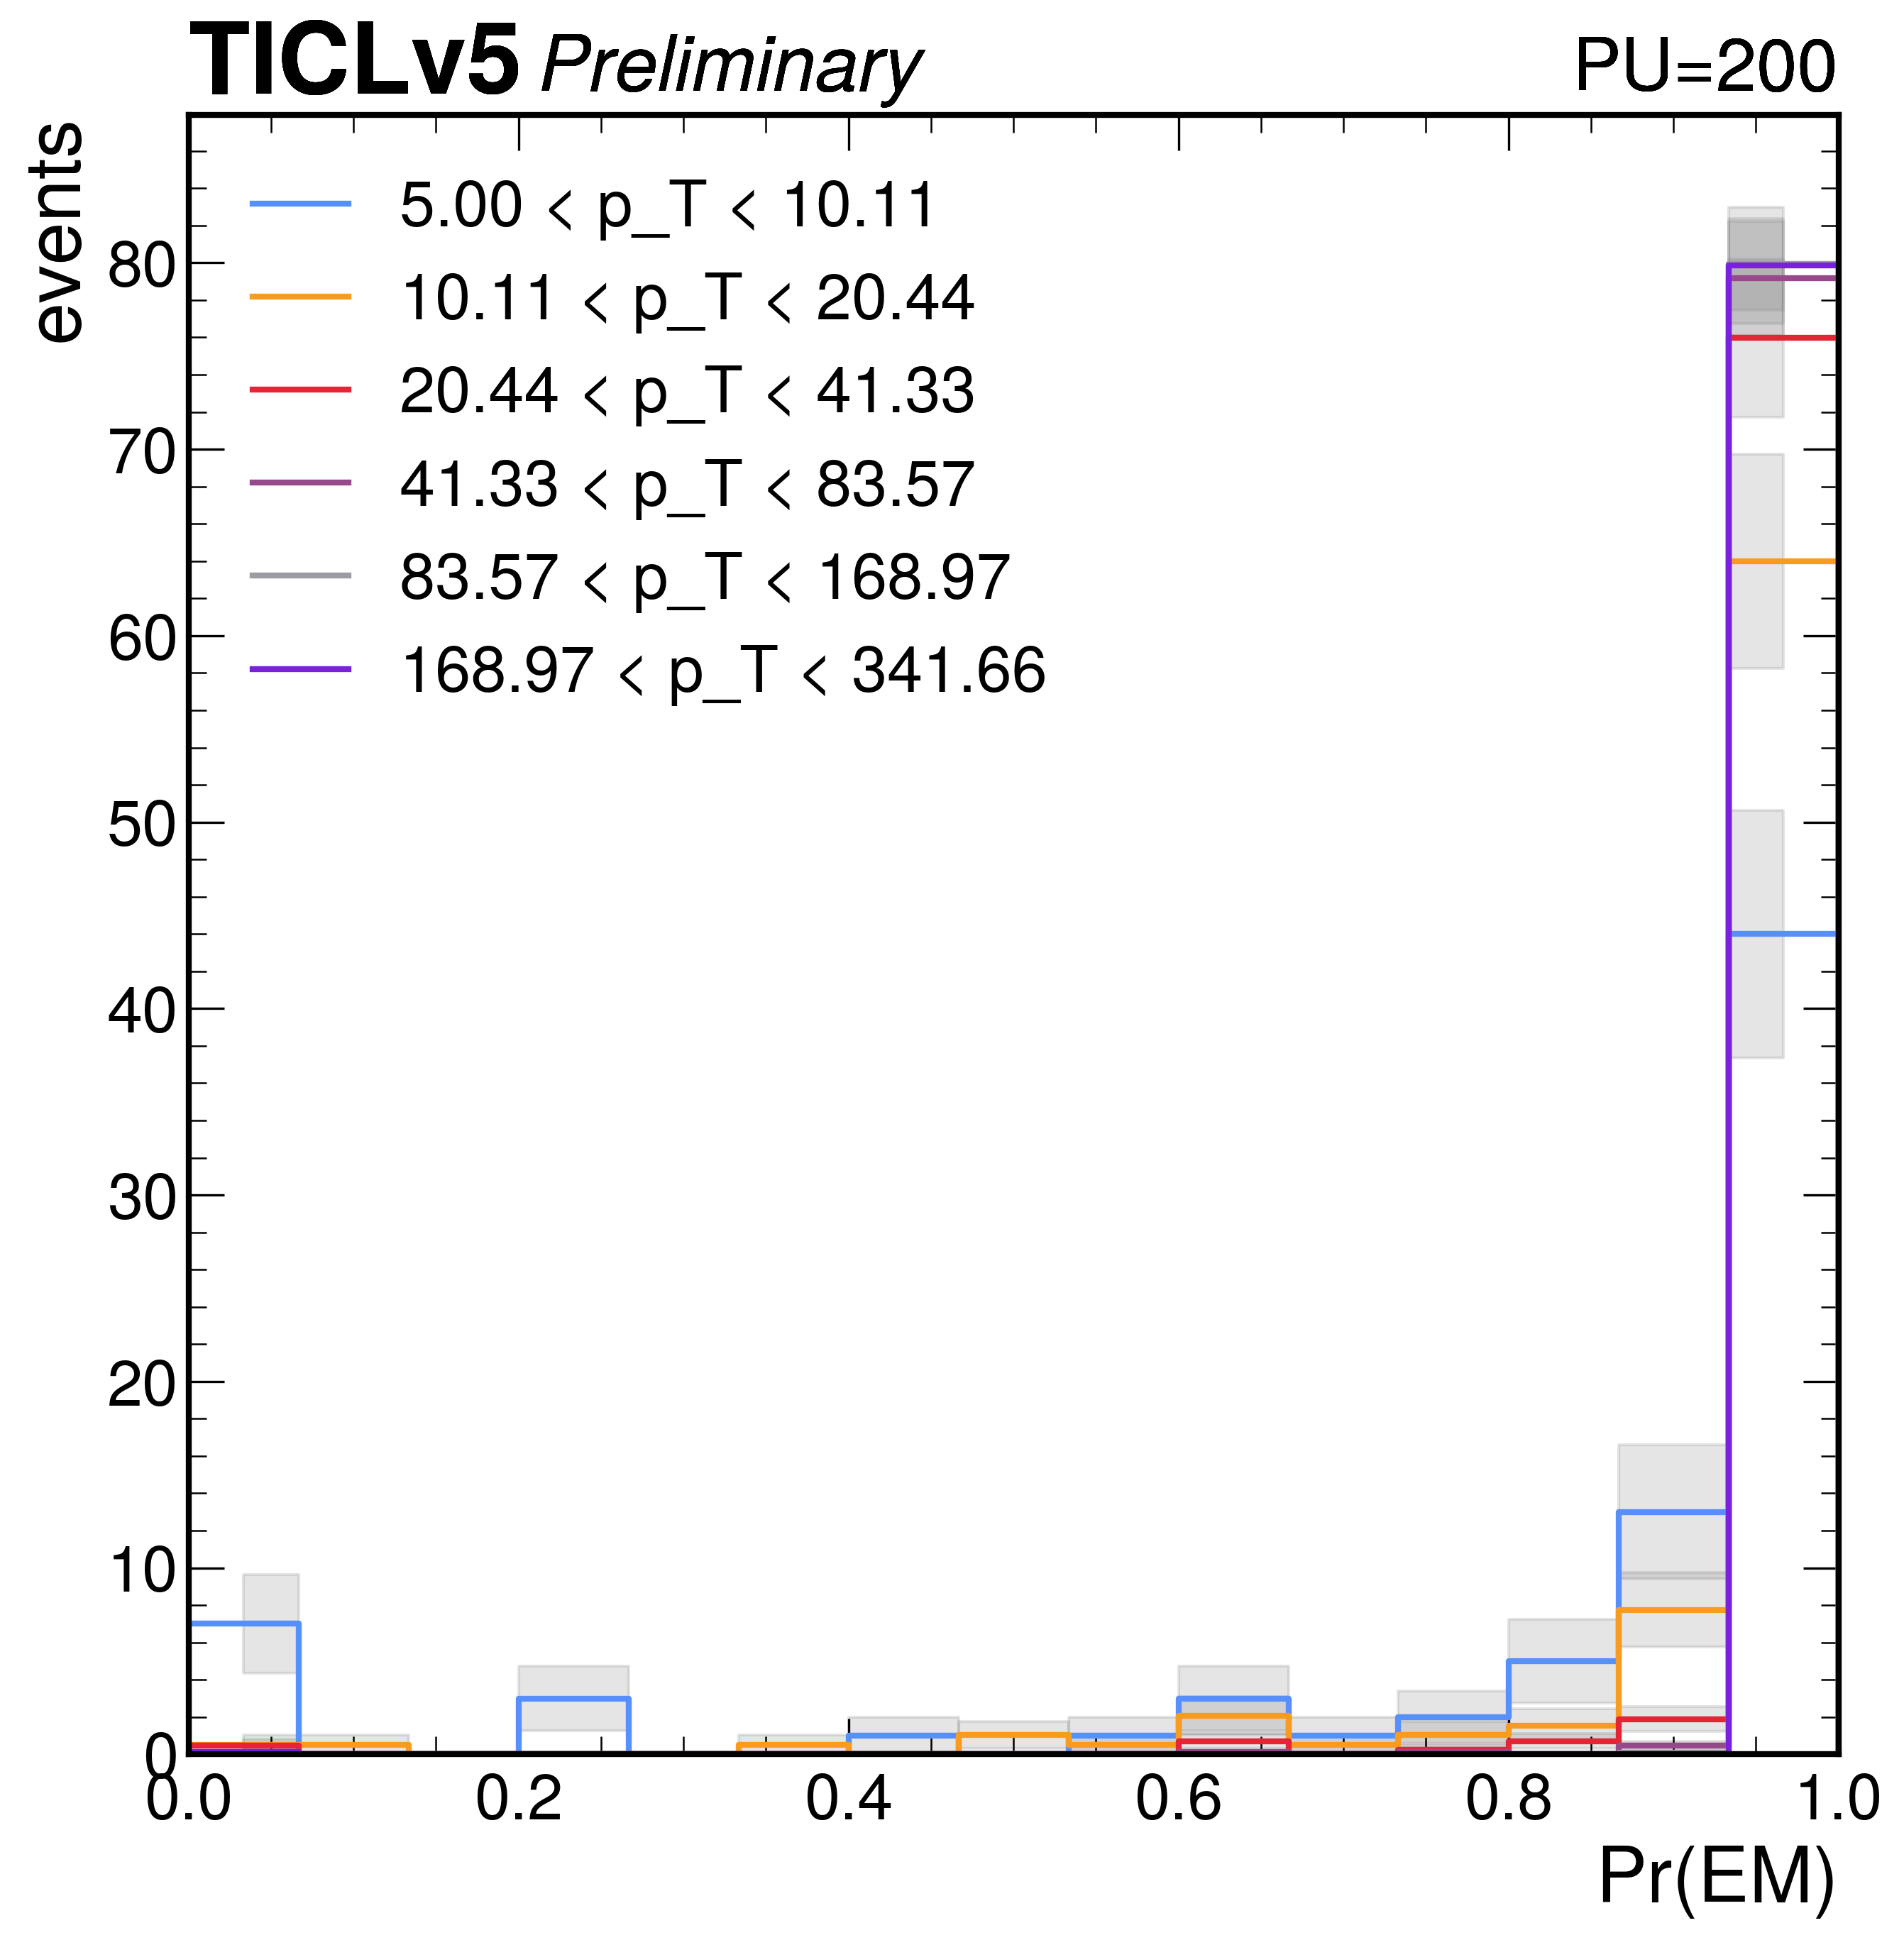

In [28]:
for i, var in enumerate(binning_keys):
    try:
        makePlotSequence(hists[2][i][0], hists[2][i][1][0], hists[2][i][2], data[2][i], gen_match)
    except:
        pass

In [21]:
# Extract data
id_prob = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="id_probabilities")

barycenter_eta = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="barycenter_eta")
energy_raw = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="raw_energy")
energy_reg = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="regressed_energy")
energy_seed = tfile.openArray(branch_name="ticlDumper/simtrackstersCP", key="raw_energy")
pt = tfile.openArray(branch_name="ticlDumper/trackstersCLUE3DHigh", key="raw_pt")

# Find boundary values for eta, energy and pT
eta_max = np.max(barycenter_eta)
eta_min = np.min(barycenter_eta)
e_raw_max = np.max(energy_raw)
e_raw_min = np.min(energy_raw)
e_reg_max = np.max(energy_reg)
e_reg_min = np.min(energy_reg)
e_seed_max = np.max(energy_seed)
e_seed_min = np.min(energy_seed)
pt_max = np.max(pt)
pt_min = np.min(pt)

# Define eta binning
eta_nbins = 3
eta_edges = np.linspace(eta_min, eta_max, eta_nbins + 1)

# Define energy binning
e_raw_nbins = 4
e_raw_edges = np.linspace(e_raw_min, e_raw_max, e_raw_nbins + 1)

# Define energy binning
e_reg_nbins = 4
e_reg_edges = np.linspace(e_reg_min, e_reg_max, e_reg_nbins + 1)

# Define energy binning
e_seed_nbins = 4
e_seed_edges = np.linspace(e_seed_min, e_seed_max, e_seed_nbins + 1)

# Define pT binning
pt_nbins = 3
pt_edges = np.linspace(pt_min, pt_max, pt_nbins + 1)

# combine edges in [eta, e, pt]
edges = [eta_edges, e_raw_edges, e_reg_edges, e_seed_edges, pt_edges]

binning_data = {
    0: barycenter_eta,
    1: energy_raw,
    2: energy_reg,
    3: energy_seed,
    4: pt
}

var_dict = {
    0: r'$\eta$',
    1: r'$E_\text{reco}^\text{raw}$',
    2: r'$E_\text{reco}^\text{regressed}$',
    3: r'$E_\text{seed}$',
    4: r'$p_T$'
}

# separate data in bins of [eta, e, pt]
id_prob_in_bins = [[], [], [], [], []]
plotLabels = [[], [], [], [], []]
for i, edges_array in enumerate(edges):
    for bin in range(len(edges_array) - 1):
        min_bin = edges_array[bin]
        max_bin = edges_array[bin + 1]
        var = var_dict[i]
        plotLabel = f'{min_bin:.2f} < {var} < {max_bin:.2f}'
        if i != 0:
            plotLabel += ' GeV'
        plotLabels[i].append(plotLabel)

        bin_map = (binning_data[i] > min_bin) & (binning_data[i] < max_bin)
        id_prob_in_bins[i].append(ak.flatten(id_prob[bin_map]))

em_prob_in_bins = [[], [], [], [], []]
for i, var in enumerate(id_prob_in_bins):
    for bin in var:
        em_prob_per_bin = bin[:, 0] + bin[:, 1]
        em_prob_in_bins[i].append(np.array(em_prob_per_bin))

em_prob_comb = np.concatenate(em_prob_in_bins[0])

# make histograms
hist_in_bins = [[[], []], [[], []], [[], []], [[], []], [[], []]]
bin_edges = np.linspace(0, 1, 11)

for i, var in enumerate(em_prob_in_bins):
    for bin in var:
        hist, _ = np.histogram(bin, bin_edges)
        hist_in_bins[i][0].append(hist)
        hist_in_bins[i][1].append(bin_edges)

norm_hist_in_bins = [[[], []], [[], []], [[], []], [[], []], [[], []]]
for i, var in enumerate(hist_in_bins):
    hists = var[0]
    n_events_per_hist = np.array([np.sum(h) for h in hists])
    weights = n_events_per_hist[0]/n_events_per_hist

    norm_hists = [hists[i]*weights[i] for i in range(len(weights))]
    for h in norm_hists:
        norm_hist_in_bins[i][0].append(h)
    for b in var[1]:
        norm_hist_in_bins[i][1].append(b)


array([ 5.        ,  3.33333333,  2.5       , 10.        , 10.        ,
        1.        ])

In [8]:
hist_in_bins

[[[array([112,  58,  35,  51,  62,  65, 119, 219, 266, 765]),
   array([122,  54,  57,  58,  59,  81, 113, 204, 353, 729]),
   array([146,  62,  64,  73,  58,  80, 106, 166, 304, 615])],
  [array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
   array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
   array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])]],
 [[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
  [array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
   array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
   array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
   array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])]],
 [[array([295, 149, 133, 150, 129, 159, 234, 360, 534, 881]),
   array([  12,   20,   21,   30,   47,   57,   93,  182,  338, 1008]),
   array([  3,   5,   2,   2,   3,  1

In [ ]:
makePlot(hist_in_bins[0][0][0], hist_in_bins[0][1][0])

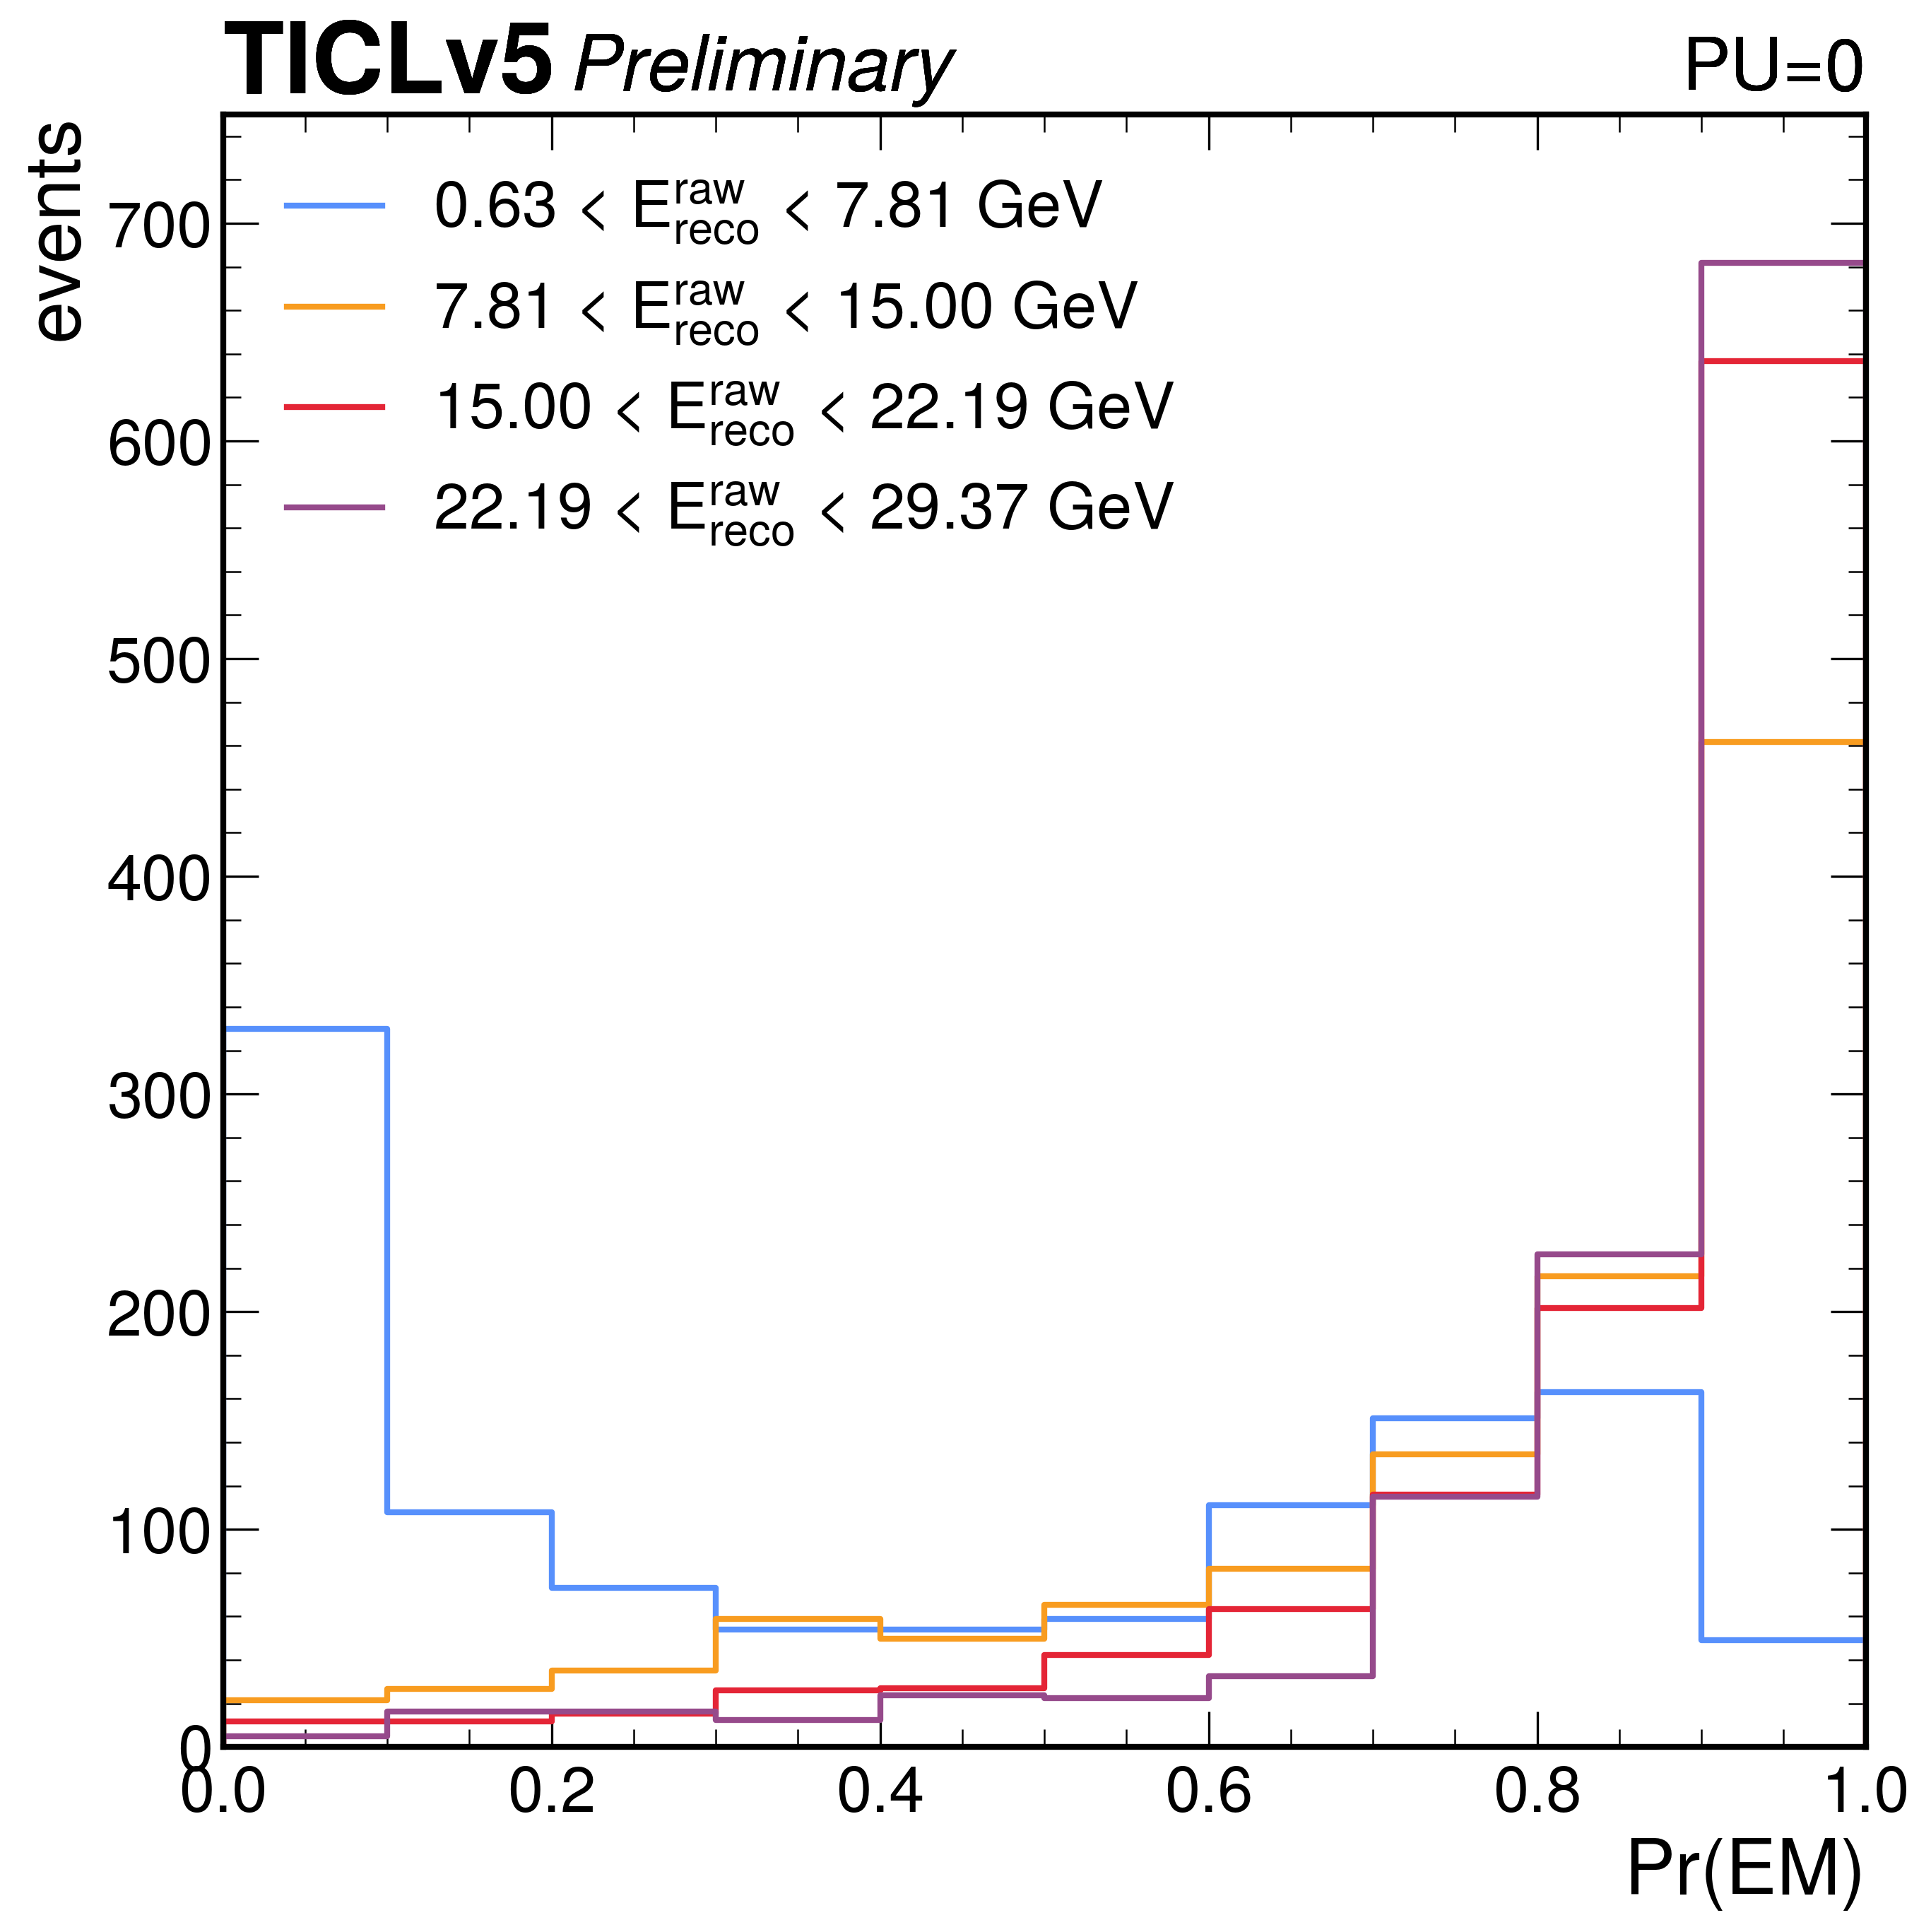

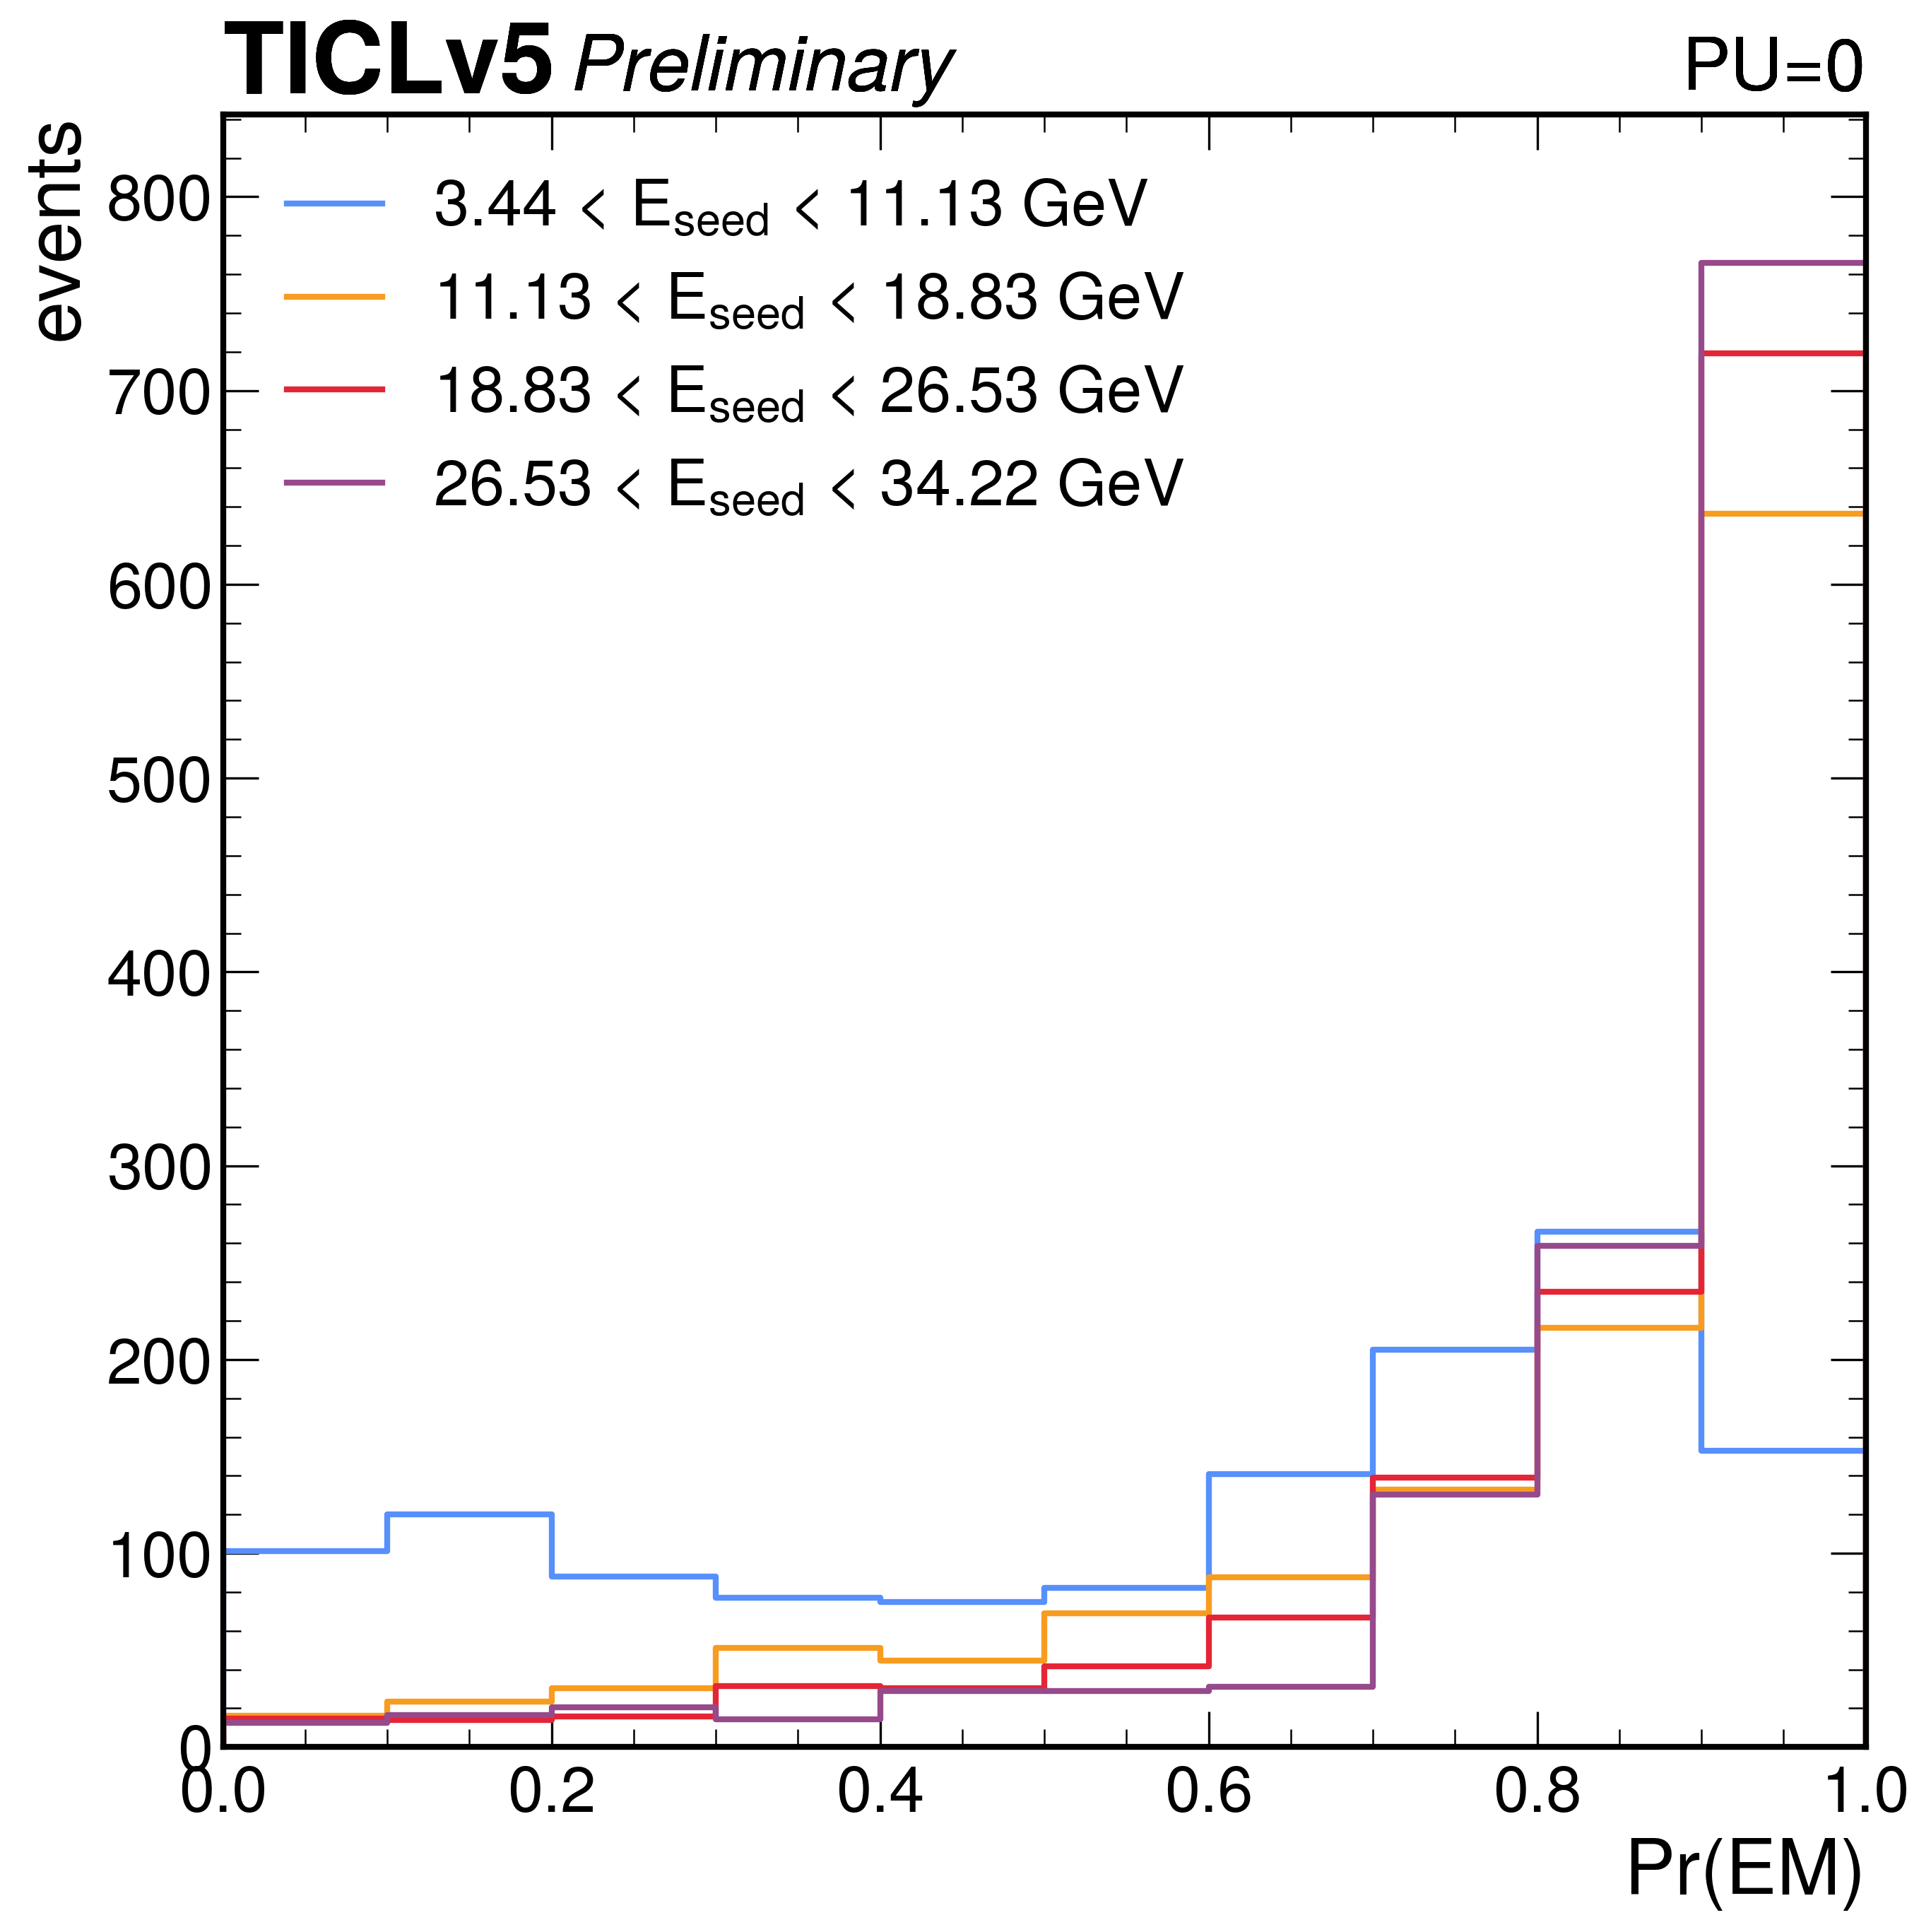

In [26]:
for var in 1, 3:
    makePlotSequence(norm_hist_in_bins[var][0], hist_in_bins[var][1][0], plotLabels[var])